#### DATABASE CONNECTION
https://docs.timescale.com/getting-started/latest/services/
<br>
After initiating a Timescale service we proceed to create a database connection using psycopg2.
<br>
There are two types of Timescale services. A “time-series service” is selected for this project because, unlike “Dynamic PostgreSQL”, it’s the one which includes the requested TimescaleDB. Both services are 100% PostgreSQL and use usage-based storage.

In [1]:
# PostgreSQL database adapter -> https://www.psycopg.org/docs/
import psycopg2
# Pandas to improve queries output for insight.
import pandas as pd

In [15]:
# DB connection, Expires on Jan 7th 2024
# Config data in timescale_credentials.sql file.  
conn = psycopg2.connect(
    host="fldr9dd2pe.ofb7ig8qpo.tsdb.cloud.timescale.com",
    port=39569,
    database="tsdb",
    user="tsdbadmin",
    password="pq8ornq2cnpjnm3p"
)
cursor = conn.cursor()

#### CONNECTION TEST

In [3]:
# Use the cursor to interact with your database
query_testing = "SELECT 'Connected';" 
cursor.execute(query_testing)
# Execution checking; alternatively use fetchone() or fetchmany() which has a "size" argument.
# The result of fetchall() is a list of tuples
print(cursor.fetchall())

[('Connected',)]


#### ANALYSIS AND INSIGHTS

Analysis Period: 30 days.

In [4]:
cursor.execute('''
    SELECT 
        MIN(time), MAX(time)
    FROM
        test_db.stock AS stk
''')
print(cursor.fetchall()) 

[(datetime.datetime(2023, 11, 8, 12, 0, 46, tzinfo=datetime.timezone.utc), datetime.datetime(2023, 12, 8, 11, 56, 48, tzinfo=datetime.timezone.utc))]


As it can be appreciated, there are trading peaks. We'll study that info. This is useful also for marketing purposes because we know "when" to serve Ads, also to estimate engineer resources (i.e. don not run heavy pipelines at those hours if limited resources), etc. 

In [5]:
cursor.execute('''
SELECT 
	DISTINCT EXTRACT(HOUR from time) AS hour, 
    SUM(day_volume) AS volume
FROM 
    test_db.company AS com
LEFT JOIN test_db.stock AS stk
    ON com.symbol = stk.symbol
GROUP BY 
    EXTRACT( hour from time)
ORDER BY 
    EXTRACT( hour from time)
''')
lst_time = cursor.fetchall()
lst_time

[(Decimal('0'), 0.0),
 (Decimal('9'), 0.0),
 (Decimal('10'), 0.0),
 (Decimal('11'), 0.0),
 (Decimal('12'), 0.0),
 (Decimal('13'), 0.0),
 (Decimal('14'), 695467766062.0),
 (Decimal('15'), 4392586208663.0),
 (Decimal('16'), 8873316426106.0),
 (Decimal('17'), 11553978206175.0),
 (Decimal('18'), 12986173732349.0),
 (Decimal('19'), 14448285576891.0),
 (Decimal('20'), 13525191079212.0),
 (Decimal('21'), 8317347559.0),
 (Decimal('22'), 0.0),
 (Decimal('23'), 0.0),
 (None, None)]

<Axes: xlabel='0'>

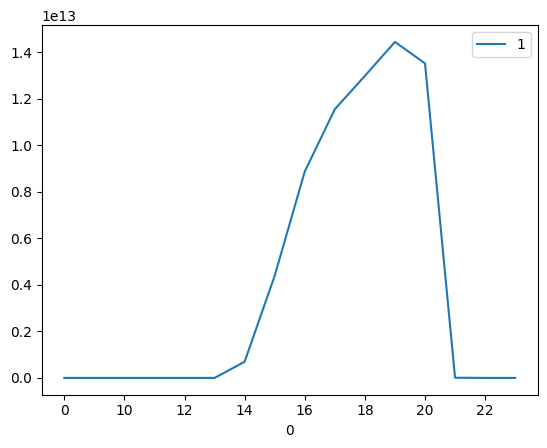

In [6]:
# quick chart, just to better visualize the output
df_timeChart = pd.DataFrame(lst_time)
df_timeChart.plot.line(x=0)

We have 100 companies in our list. We will look for the top 5 regarding JUST volumen in our montly period. Once having that top 5 we'll compare the last week performance compared to the week before (LW) to see if there is a trend at first glance (no maths involved).
<br>
This will be a rank of the top 5 and not just filtering the top 5 with SQL LIMIT expression because in some cases a position could be share and we would miss that info. 

In [7]:
# the four dates that we are going to work with: start and end date of the last week and the previous one. 
cursor.execute('''
	SELECT 
		MAX(time::DATE) as this_week_end_date,
		CAST(
			(MAX(time) - INTERVAL '6 day')
			AS DATE) AS this_week_start_date,
		CAST(
			(MAX(time) - INTERVAL '7 day')
			AS DATE) AS last_week_end_date,
		CAST(
			(MAX(time) - INTERVAL '13 day')
			AS DATE) AS last_week_start_date
	FROM
		test_db.stock;
''')
pd.DataFrame(cursor.fetchall()).rename(columns={0: "this_week_end_date", 1: "this_week_start_date",2: "last_week_end_date", 3: "last_week_start_date"})


,this_week_end_date,this_week_start_date,last_week_end_date,last_week_start_date
0,2023-12-08,2023-12-02,2023-12-01,2023-11-25


In [8]:
# the tables and field names are self descriptive to avoid extra comments
analysis_query = '''
    WITH time_table AS (
        SELECT 
            MAX(time::DATE) as this_week_end_date,
            CAST(
                (MAX(time) - INTERVAL '6 day')
                AS DATE) AS this_week_start_date,
            CAST(
                (MAX(time) - INTERVAL '7 day')
                AS DATE) AS last_week_end_date,
            CAST(
                (MAX(time) - INTERVAL '13 day')
                AS DATE) AS last_week_start_date
        FROM
            test_db.stock
    ),
    this_week_sum AS (
        SELECT DISTINCT
            com.name AS company_name, 
            SUM(stk.day_volume) AS volume_sum
        FROM 
            test_db.company AS com
        LEFT JOIN test_db.stock AS stk
            ON com.symbol = stk.symbol
        WHERE
            stk.time BETWEEN 
                (SELECT this_week_start_date FROM time_table) 
                AND 
                (SELECT this_week_end_date FROM time_table)
        GROUP BY
            com.name
    ),
    this_week_top_5_companies AS (
        SELECT
            company_name
        FROM (
            SELECT
                company_name,
                --volume_sum,
                RANK() OVER(
                    ORDER BY volume_sum DESC
                    ) AS rank_companies
            FROM (
                SELECT * FROM this_week_sum
                ) t1
            ) AS t2
        WHERE
            rank_companies <=5
    ),
    this_week_total AS ( 
        SELECT SUM(volume_sum) AS volume_total 
        FROM this_week_sum
    ),
    last_week_sum AS (
        SELECT DISTINCT
            com.name AS company_name, 
            SUM(stk.day_volume) AS volume_sum
        FROM 
            test_db.company AS com
        LEFT JOIN test_db.stock AS stk
            ON com.symbol = stk.symbol
        WHERE
            stk.time BETWEEN 
                (SELECT last_week_start_date FROM time_table) 
                AND 
                (SELECT last_week_end_date FROM time_table)
        GROUP BY
            com.name
    )
       
    SELECT
        tw.company_name,
        ROUND(tw.volume_sum/1000000) AS "volume(M)",
        ROUND((tw.volume_sum/(SELECT * FROM this_week_total)*100)::NUMERIC,1) AS "share(%)",
        -- ROUND(lw.volume_sum/1000000) AS "LW_volume(M)",
        ROUND(tw.volume_sum/lw.volume_sum*100) AS "volume_Vs_LW(%)"
    FROM 
        this_week_sum AS tw
    INNER JOIN last_week_sum AS lw
        ON tw.company_name = lw.company_name
    WHERE 
        tw.company_name IN (SELECT * FROM this_week_top_5_companies);

'''
cursor.execute(analysis_query)
pd.DataFrame(cursor.fetchall()).rename(columns={0: "company", 1: "volume(M)", 2: "share(%)", 3: "volume_Vs_LW(%)"})

,company,volume(M),share(%),volume_Vs_LW(%)
0,AMD,564955.0,16.1,147.0
1,Amazon,200805.0,5.7,41.0
2,Apple,289676.0,8.3,40.0
3,NVIDIA,167954.0,4.8,37.0
4,Tesla,652518.0,18.6,39.0


Share is the "total share", not just among the top 5.
<br>
In this case we appreciate that AMD is the only one that has growth compared to the previous analysis period. 
<br>
For further study we could multiply the volume by the price value to have the total sales. 

Here below we use a Timescale time-series functionality, first() & last(), and the "bucket" function to group by week.
<br>
Study case: for AMD, on 2023/12/01, we need to knwo the initial and final price to study that daily variaition figure. 

In [16]:
price_query = '''
	SELECT
		time_bucket('7 day', time)::DATE AS week,
		first(price,time),
		last(price,time)
	FROM 
		test_db.stock
	WHERE 1=1
		AND symbol = 'AMD'
	GROUP BY 
		week
'''
cursor.execute(price_query)
pd.DataFrame(cursor.fetchall()).rename(columns={0: "week", 1: "init_price", 2: "final_price"})

,week,init_price,final_price
0,2023-11-06,113.61,118.91
1,2023-11-13,117.96,120.84
2,2023-11-20,120.64,122.19
3,2023-11-27,121.94,121.48
4,2023-12-04,117.27,128.78


####  END SESSION

In [12]:
# commit changes to the database to make changes persistent
conn.commit()

In [13]:
# close cursor to end session and release resources.
cursor.close()